<a href="https://colab.research.google.com/github/yetanotherpassword/COMS4507/blob/main/Project4507_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [40]:
from google.colab import drive
drive.mount('/content/drive')

# Set the working directory for the assignment
import os
SKELETON_DIR = '/content/drive/MyDrive/Uni/COMS4507/Project/'
os.chdir(SKELETON_DIR)

# Now go to https://finance.yahoo.com/quote/BTC-USD/history?p=BTC-USD
# and select "Time Period: Max"
#            "Show:Historical Prices"
#            "Frequency:Daily"
# and click Download ---> will get BTC-USD.csv

def preprocess_data(data_url):
    df = pd.read_csv(data_url)
    df = df.drop(['Adj Close'], axis=1)
    #df.rename(columns={'Date': 'ds', 'Close': 'y'}, inplace=True)
    return df

import IPython
from IPython.display import display, HTML, Javascript

def configure_browser_state():
  display(IPython.core.display.HTML('''
    <canvas id="myChart"></canvas>
  '''))
  display(IPython.core.display.HTML('''
        <script src="https://cdn.jsdelivr.net/npm/chart.js@2.8.0"></script>
        <script>
          var ctx = document.getElementById('myChart').getContext('2d');
          var chart = new Chart(ctx, {
              // The type of chart we want to create
              type: 'line',

              // The data for our dataset
              data: {
                  labels: [],
                  datasets: [{
                      label: 'Actual',
                      borderColor: 'rgb(255, 99, 132)',
                      data: []
                  }, 
                  {
                      label: 'Predicted',
                      borderColor: 'rgb(155, 199, 32)',
                      data: []
                  }]
              },
              // Configuration options go here
              options: { animation: {duration: 0} ,
                scales: {x: {
                           type: 'time',
                           time: { unit: 'day',unitStepSize: 1,displayFormats: {day: 'YYYY-MM-DD'},tooltipFormat: 'YYYY-MM-DD'},
                           title: {display: true, text: 'Date'}},
                         y: {
                           title: { display: true, text: 'value'}},
                         xAxes: [{ scaleLabel: { display: true, labelString: 'Timestamp [YYYY-MM-DD]'}}], 
                        // xAxes : [time: { unit: 'day',unitStepSize: 1,displayFormats: {day: 'YYYY MM DD'},tooltipFormat: 'YYYY MM DD'},],
                        yAxes: [{scaleLabel: {display: true, labelString: 'BitCoin Price [$USD Normalised]'} }], },
                title: { display: true, text: 'Bitcoin Price - Realtime Prediction'}}});


          function getEpoch(offset_sec=0) {
             var now     = new Date(); 
             return Math.floor((now.getTime() - offset_sec*1000)/1000);}

          function getDateTime(offset_sec=0) {
             var now     = new Date(); 
             var numberOfMlSeconds = now.getTime() + offset_sec*1000;
             var update_now = new Date (numberOfMlSeconds);
             var year    = update_now.getFullYear();
             var month   = update_now.getMonth()+1; 
             var day     = update_now.getDate();
             var hour    = update_now.getHours();
             var minute  = update_now.getMinutes();
             var second  = update_now.getSeconds(); 
             if(month.toString().length == 1) {
                 month = '0'+month;}
             if(day.toString().length == 1) {
                 day = '0'+day;}   
             if(hour.toString().length == 1) {
                 hour = '0'+hour;}
             if(minute.toString().length == 1) {
                 minute = '0'+minute; }
             if(second.toString().length == 1) {
                 second = '0'+second;}   
             //var dateTime = year+'-'+month+'-'+day+' '+hour+':'+minute+':'+second;   
             var dateTime = year+'-'+month+'-'+day;  
             return dateTime;
          }

          function addData(current, predicted, day){
            chart.data.labels.push(day)
            if (chart.data.datasets[1].data.length > 0)
            //chart.data.datasets[0].data[chart.data.datasets[0].data.length - 1] = current
               chart.data.datasets[0].data.push(current)
            chart.data.datasets[1].data.push(predicted)
            // optional windowing
            if(chart.data.labels.length > 100) {
              chart.data.labels.shift()
              chart.data.datasets[0].data.shift()
              chart.data.datasets[1].data.shift() 
            }
            chart.update();
          }
        </script>
        '''))
    

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Streaming output truncated to the last 5000 lines.
 [0.19057144 0.18354898 0.18894701 0.17722084 0.42989209]
 [0.17758725 0.16880235 0.18890935 0.17926714 0.31914735]
 [0.1794554  0.2026305  0.19319423 0.21725674 0.50646232]
 [0.21740472 0.21233278 0.23148873 0.22274743 0.27077555]
 [0.22308963 0.2081829  0.22401842 0.20830923 0.2459426 ]
 [0.20847706 0.1962401  0.20590635 0.1951898  0.41154774]
 [0.19534369 0.1803519  0.0843887  0.11162841 1.        ]
 [0.1119536  0.09555726 0.00352145 0.00378971 0.85543092]
 [0.0040889  0.0736387  0.00989223 0.0729393  0.67837058]
 [0.07301315 0.0571483  0.03976042 0.05054548 0.43276281]
 [0.05086224 0.03326247 0.04431952 0.04101578 0.19772994]
 [0.04124775 0.02729741 0.03037861 0.02294518 0.17518709]
 [0.02309757 0.035006   0.01153087 0.03367979 0.37667454]
 [0.03385954 0.03266098 0.0397212  0.04447846 0.25957285]
 [0.04467833 0.02891344 0.03498754 0.03575673 0.23554357]
 [0.03600586 0.01935304 0.03627462 0.0364895  0.18111578]
 [0.03671478 0.028372

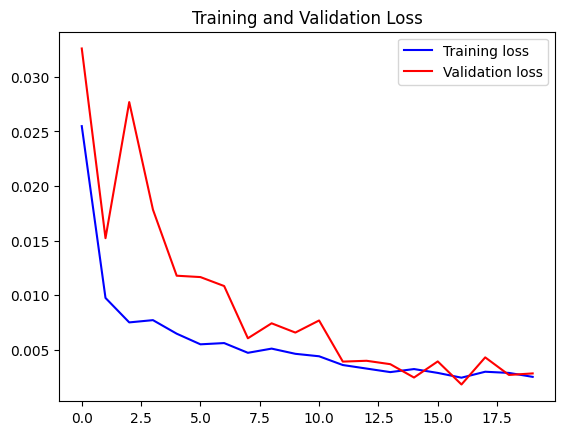

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
from datetime import datetime, timedelta

data = pd.read_csv(SKELETON_DIR+'BTC-USD.csv', date_parser = True)
print(data.tail())

last_trainingdate = str(last_date+timedelta(days=-60))

data_training = data[data['Date']< last_trainingdate[0:10]].copy()
data_training
print("Above is data_training")

data_test = data[data['Date']>= last_trainingdate[0:10]].copy()
data_test
print("Above  is data_test")

train_dates = data_training['Date']
print("Train_dates.shape=",train_dates.shape[0])
print("Traing_data=",data_training)
training_data = data_training.drop(['Date', 'Adj Close'], axis = 1)
print("Traing_data2=",training_data)
print("Training from "+str(train_dates[0])+" to "+str(train_dates[train_dates.shape[0]-1]))

#normalise the data
scaler = MinMaxScaler()
training_data = scaler.fit_transform(training_data)
print("Traing_data3=",training_data)

X_train = [] 
Y_train = []

# train the timeseries of the past 60 days for bitcoin price on that 60th day
# do this over each day of the data
for i in range(60, training_data.shape[0]):
  print("training for date: ",train_dates[i])
  print("X_Train=",training_data[i-60:i])
  print("Y_Train=",training_data[i,0])
  X_train.append(training_data[i-60:i])
  Y_train.append(training_data[i,0])
X_train, Y_train = np.array(X_train), np.array(Y_train)
print("xtrain.shape=",X_train.shape)

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
#Initialize the RNN
model = Sequential() 
model.add(LSTM(units = 50, activation = 'relu', return_sequences = True, input_shape = (X_train.shape[1], 5)))

model.add(Dropout(0.2)) 
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3)) 
model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))

model.add(Dropout(0.4)) 
model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5)) 
model.add(Dense(units =1))
model.summary()

model.compile(optimizer = 'adam', loss = 'mean_squared_error')
history= model.fit(X_train, Y_train, epochs = 20, batch_size =50, validation_split=0.1)
                   
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(loss))
plt.figure()
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title("Training and Validation Loss")
plt.legend()
plt.show()




dates= 0      2022-12-24
1      2022-12-25
2      2022-12-26
3      2022-12-27
4      2022-12-28
          ...    
116    2023-04-19
117    2023-04-20
118    2023-04-21
119    2023-04-22
120    2023-04-23
Name: Date, Length: 121, dtype: object


<ipython-input-41-14d20f6ccddf>:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sim_data = tmp.append(data_test, ignore_index = True)


Predicting for Date 2023-02-22
1/1 [==============================] - 0s 43ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-02-23
1/1 [==============================] - 0s 47ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-02-24
1/1 [==============================] - 0s 58ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-02-25
1/1 [==============================] - 0s 48ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-02-26
1/1 [==============================] - 0s 46ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-02-27
1/1 [==============================] - 0s 51ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-02-28
1/1 [==============================] - 0s 49ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-01
1/1 [==============================] - 0s 57ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-02
1/1 [==============================] - 0s 52ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-03
1/1 [==============================] - 0s 57ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-04
1/1 [==============================] - 0s 60ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-05
1/1 [==============================] - 0s 63ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-06
1/1 [==============================] - 0s 62ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-07
1/1 [==============================] - 0s 60ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-08
1/1 [==============================] - 0s 63ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-09
1/1 [==============================] - 0s 59ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-10
1/1 [==============================] - 0s 60ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-11
1/1 [==============================] - 0s 62ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-12
1/1 [==============================] - 0s 67ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-13
1/1 [==============================] - 0s 62ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-14
1/1 [==============================] - 0s 69ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-15
1/1 [==============================] - 0s 67ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-16
1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-17
1/1 [==============================] - 0s 57ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-18
1/1 [==============================] - 0s 79ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-19
1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-20
1/1 [==============================] - 0s 74ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-21
1/1 [==============================] - 0s 79ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-22
1/1 [==============================] - 0s 91ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-23
1/1 [==============================] - 0s 71ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-24
1/1 [==============================] - 0s 75ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-25
1/1 [==============================] - 0s 75ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-26
2/2 [==============================] - 0s 22ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-27
2/2 [==============================] - 0s 32ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-28
2/2 [==============================] - 0s 38ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-29
2/2 [==============================] - 0s 25ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-30
2/2 [==============================] - 0s 28ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-03-31
2/2 [==============================] - 0s 31ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-01
2/2 [==============================] - 0s 27ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-02
2/2 [==============================] - 0s 28ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-03
2/2 [==============================] - 0s 31ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-04
2/2 [==============================] - 0s 33ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-05
2/2 [==============================] - 0s 48ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-06
2/2 [==============================] - 0s 66ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-07
2/2 [==============================] - 0s 72ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-08
2/2 [==============================] - 0s 63ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-09
2/2 [==============================] - 0s 59ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-10
2/2 [==============================] - 0s 53ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-11
2/2 [==============================] - 0s 55ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-12
2/2 [==============================] - 0s 57ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-13
2/2 [==============================] - 0s 57ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-14
2/2 [==============================] - 0s 64ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-15
2/2 [==============================] - 0s 60ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-16
2/2 [==============================] - 0s 61ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-17
2/2 [==============================] - 0s 62ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-18
2/2 [==============================] - 0s 43ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-19
2/2 [==============================] - 0s 54ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-20
2/2 [==============================] - 0s 61ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-21
2/2 [==============================] - 0s 54ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-22
2/2 [==============================] - 0s 57ms/step


<IPython.core.display.Javascript object>

Predicting for Date 2023-04-23
2/2 [==============================] - 0s 65ms/step


<IPython.core.display.Javascript object>

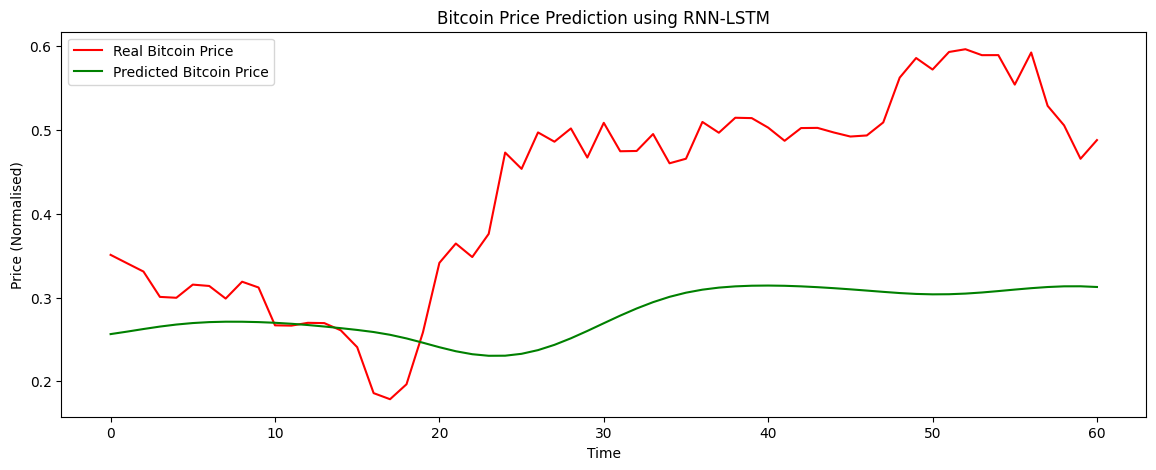

In [41]:
tmp = data_training.tail(60)
sim_data = tmp.append(data_test, ignore_index = True)
dates = sim_data['Date']
print("dates=",dates)

sim_data = sim_data.drop(['Date', 'Adj Close'], axis = 1)

inputs = scaler.transform(sim_data) 

# Ready graph display
configure_browser_state() 

X_test = []
Y_test = []
for i in range (60, inputs.shape[0]):
    print("Predicting for Date", dates[i])
    X_test.append(inputs[i-60:i]) 
    Y_test.append(inputs[i, 0])
    Y_pred = model.predict(np.array(X_test))
    display(Javascript('addData('+str(Y_test[-1])+','+str(Y_pred[-1])+',"'+str(dates[i])+'")'))

plt.figure(figsize=(14,5))
plt.plot(Y_test, color = 'red', label = 'Real Bitcoin Price')
plt.plot(Y_pred, color = 'green', label = 'Predicted Bitcoin Price')
plt.title('Bitcoin Price Prediction using RNN-LSTM')
plt.xlabel('Time')
plt.ylabel('Price (Normalised)')
plt.legend()
plt.show()

